# 1. Import Libraries

In [1]:
from google.colab import drive

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

In [2]:
drive.mount('./gdrive')

Mounted at ./gdrive


In [3]:
!mkdir /root/.kaggle/
!cp /content/gdrive/MyDrive/data-study/kaggle/kaggle.json /root/.kaggle/   # kaggle.json 위치 지정
!chmod 600 /root/.kaggle/kaggle.json

# 2. Define Instance Normalization and AdaIN

In [9]:
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

In [10]:
def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# 3. Set Encoder and Decoder Networks

In [11]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

In [12]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

# 4. Load Pre-trained Models

In [13]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-07-20 04:48:03--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPVlIR1VqemxMMlVn [following]
--2021-07-20 04:48:04--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9

In [14]:
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

# 5. AdaIN Style Transfer Network<br>
* Not used in this practice<br>
* Reference for network architecture

In [ ]:
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4]) # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11]) # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18]) # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image (중간 결과를 기록)
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image (최종 결과만 기록)
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    # 콘텐츠 손실(feature 값 자체가 유사해지도록)
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    # 스타일 손실(feature의 statistics가 유사해지도록)
    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        # 콘텐츠와 스타일 중 어떤 것에 더 많은 가중치를 둘지 설정 가능
        assert 0 <= alpha <= 1 # 0에 가까울수록 콘텐츠를 많이 살림
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t) # 결과 이미지
        g_t_feats = self.encode_with_intermediate(g_t)

        # 콘텐츠 손실과 스타일 손실을 줄이기 위해 두 개의 손실 값 반환
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

# 6. Load Content and Style Images

In [5]:
!kaggle datasets download -d kostastokis/simpsons-faces --unzip

 97% 429M/442M [00:03<00:00, 147MB/s]
100% 442M/442M [00:03<00:00, 137MB/s]


In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset --unzip

 99% 1.32G/1.33G [00:10<00:00, 170MB/s]
100% 1.33G/1.33G [00:10<00:00, 130MB/s]


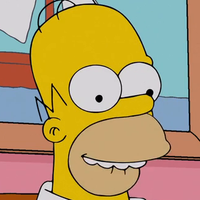

In [7]:
display_image('./cropped/1.png')

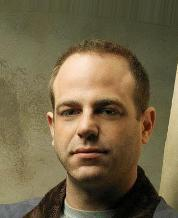

In [8]:
display_image('./img_align_celeba/img_align_celeba/000025.jpg')

# 7. Style Transfer Function

In [15]:
def style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [16]:
def test_transform(size=512):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

content_tf = test_transform()
style_tf = test_transform()

# 8. Run Style Transfer

In [23]:
content_path = './img_align_celeba/img_align_celeba/000025.jpg'
style_path = './cropped/1.png'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=0.9)
output = output.cpu()

save_image(output, 'output.png')

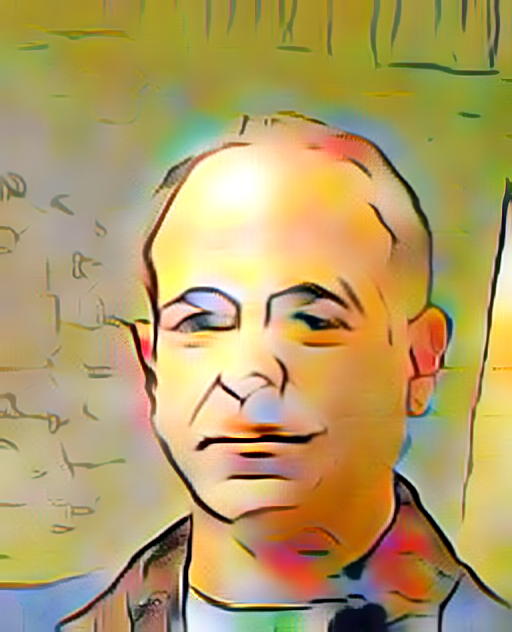

In [24]:
# 결과 이미지 출력
display_image('./output.png')

In [29]:
content_path = './img_align_celeba/img_align_celeba/000002.jpg'
style_path = './cropped/1000.png'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=0.9)
output = output.cpu()

save_image(output, 'output2.png')

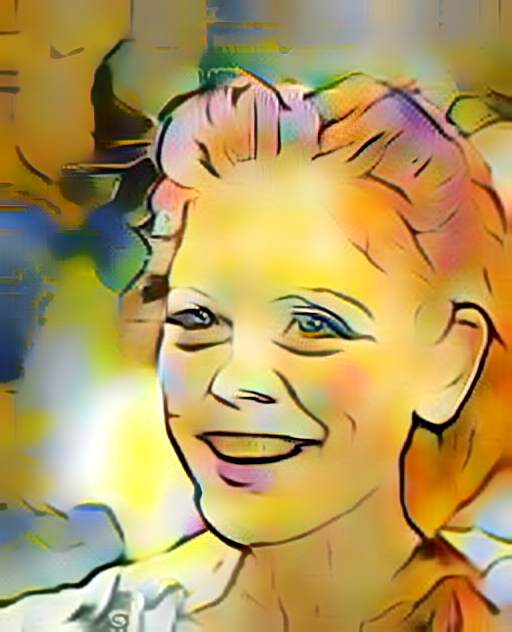

In [30]:
# 결과 이미지 출력
display_image('./output2.png')

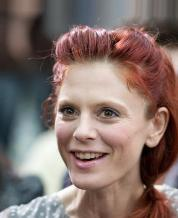

In [31]:
display_image('./img_align_celeba/img_align_celeba/000002.jpg')

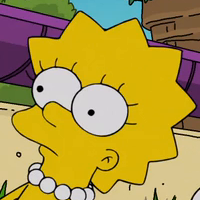

In [32]:
display_image('./cropped/1000.png')